In [27]:
!pip install catboost


In [28]:
!pip install numerize

In [29]:
!pip install category_encoders

In [30]:
!pip install shap

In [31]:
pip install dask

In [33]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use("ggplot")
import missingno as mso
from numerize import numerize

# Stats
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import norm

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import recall_score, fbeta_score
from sklearn.metrics import confusion_matrix
# Typing
from typing import Dict, List

# Time
import time

# Shap values
import shap

# Warnings
import warnings
warnings.filterwarnings("ignore")



In [34]:
data = pd.read_csv("/content/sample_data/Loan_default.csv")
data.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [35]:
print("Data set size:")
print(f"{data.shape[0]}rows")
print(f"{data.shape[1]}columns")

Data set size:
255347rows
18columns


In [36]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

**EDA**

In [37]:
print("Duplicate rows:")
print(data.duplicated().sum())

Duplicate rows:
0


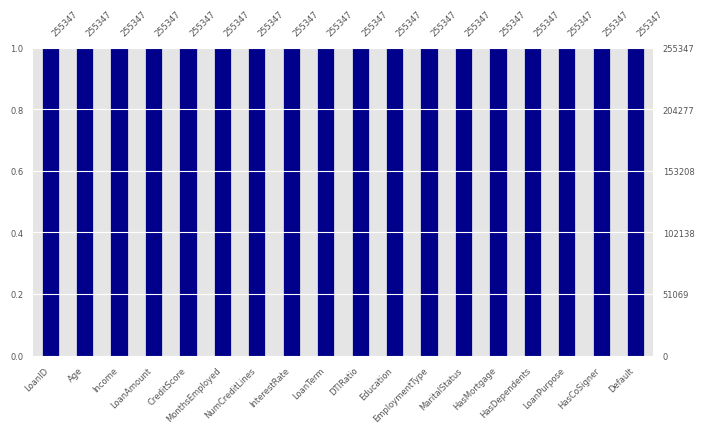

In [38]:
fig,ax = plt.subplots(figsize = (8,4))
mso.bar(data,fontsize = 6, color = 'darkblue',ax = ax)
fig.show()# here we had found that no columns is having null value through visualisation

In [39]:
data.drop('LoanID',axis =1, inplace = True) # As Loanid doesn't provide us any insight or value so we can eliminate it

In [40]:
   ## We select the quantitative and categorical variables to carry out the exploratory analysis of the data.(EDA)
# Quantitative variables:
num_cols = ["Age", "Income", "LoanAmount", "CreditScore", "MonthsEmployed",
            "NumCreditLines", "InterestRate", "LoanTerm", "DTIRatio"]

# Categorical variables:
cat_cols = ["Default", "Education", "EmploymentType", "MaritalStatus",
            "HasMortgage", "HasDependents", "LoanPurpose", "HasCoSigner"]

In [41]:
#now we visualise each of the quantitative variables.
# We visualize each of the quantitative variables.
print("**"*30)
print(" "*15, f"Total Quantitative variables = {len(num_cols)}")
print("**"*30)
for col in num_cols:
  print(f"* {col}")

************************************************************
                Total Quantitative variables = 9
************************************************************
* Age
* Income
* LoanAmount
* CreditScore
* MonthsEmployed
* NumCreditLines
* InterestRate
* LoanTerm
* DTIRatio


In [42]:
# We visualize each of the categorical variables in detail.
print("**"*30)
print(" "*15, f"Total Categorical variables = {len(cat_cols)}")
print("**"*30)
for col in cat_cols:
  print(f"* {col} => {data[col].unique()} => {data[col].nunique()} values")

************************************************************
                Total Categorical variables = 8
************************************************************
* Default => [0 1] => 2 values
* Education => ["Bachelor's" "Master's" 'High School' 'PhD'] => 4 values
* EmploymentType => ['Full-time' 'Unemployed' 'Self-employed' 'Part-time'] => 4 values
* MaritalStatus => ['Divorced' 'Married' 'Single'] => 3 values
* HasMortgage => ['Yes' 'No'] => 2 values
* HasDependents => ['Yes' 'No'] => 2 values
* LoanPurpose => ['Other' 'Auto' 'Business' 'Home' 'Education'] => 5 values
* HasCoSigner => ['Yes' 'No'] => 2 values


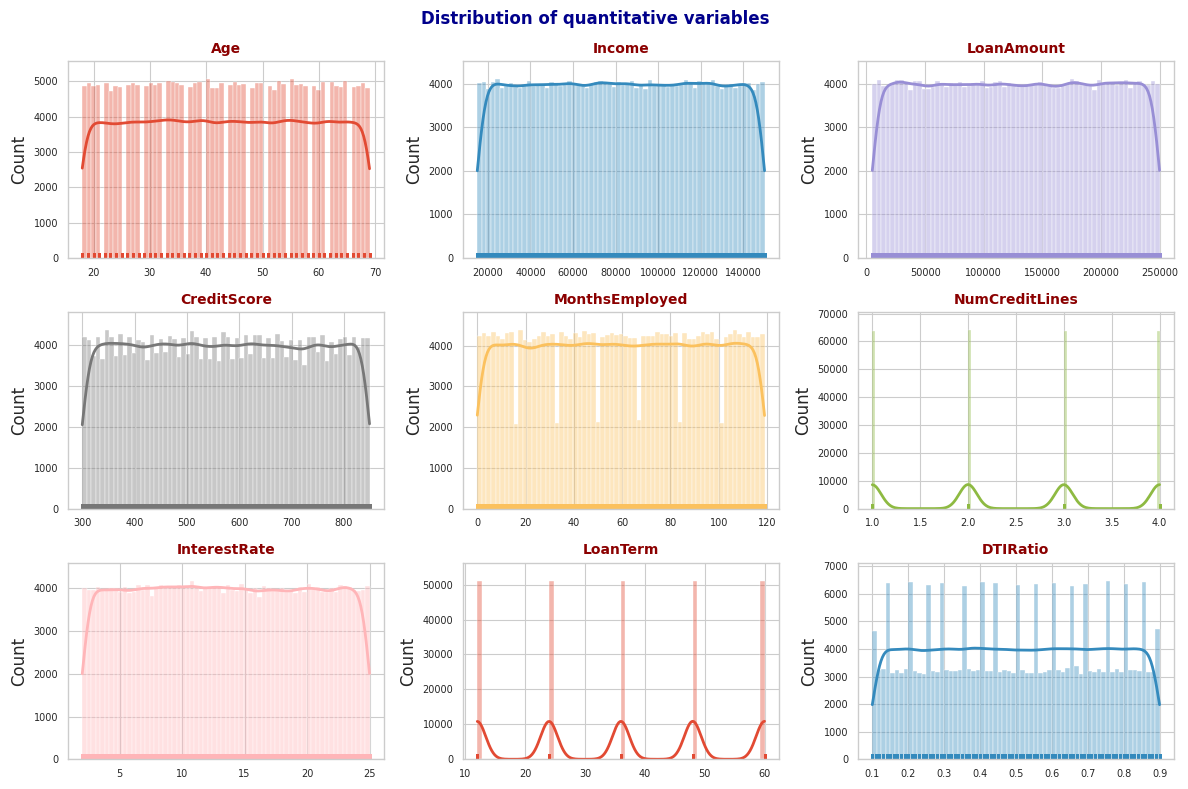

In [43]:
# Let's visualize the distribution of the quantitative variables.
sns.set_style("whitegrid")
fig,axes = plt.subplots(nrows = 3, ncols = 3, figsize = (12,8))
axes = axes.flat

for i,col in enumerate(num_cols):
  sns.histplot(data,
               x = col,
               stat = "count",
               kde = True,
               line_kws = {"linewidth":2.0},
               alpha = 0.4,
               color = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
               ax = axes[i])
  sns.rugplot(data,
              x = col,
              color = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
              ax = axes[i])

  axes[i].set_xlabel("")
  axes[i].set_title(f"{col}", fontsize = 10, fontweight = "bold", color = "darkred")
  axes[i].tick_params(labelsize = 7)

fig.suptitle("Distribution of quantitative variables", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()

In [44]:
# Now let's check your skewness and kurtosis of each numerical variable.

for col in num_cols:
  print(f"* {col}:")
  print("Skewness: %f" % data[col].skew())
  print("Kurtosis: %f" % data[col].kurt())
  print("=================================")

* Age:
Skewness: 0.000698
Kurtosis: -1.198431
* Income:
Skewness: -0.000381
Kurtosis: -1.198361
* LoanAmount:
Skewness: -0.001827
Kurtosis: -1.203680
* CreditScore:
Skewness: 0.004688
Kurtosis: -1.200302
* MonthsEmployed:
Skewness: -0.002142
Kurtosis: -1.199632
* NumCreditLines:
Skewness: -0.000278
Kurtosis: -1.357671
* InterestRate:
Skewness: 0.004608
Kurtosis: -1.197167
* LoanTerm:
Skewness: -0.002178
Kurtosis: -1.299895
* DTIRatio:
Skewness: -0.001499
Kurtosis: -1.199675


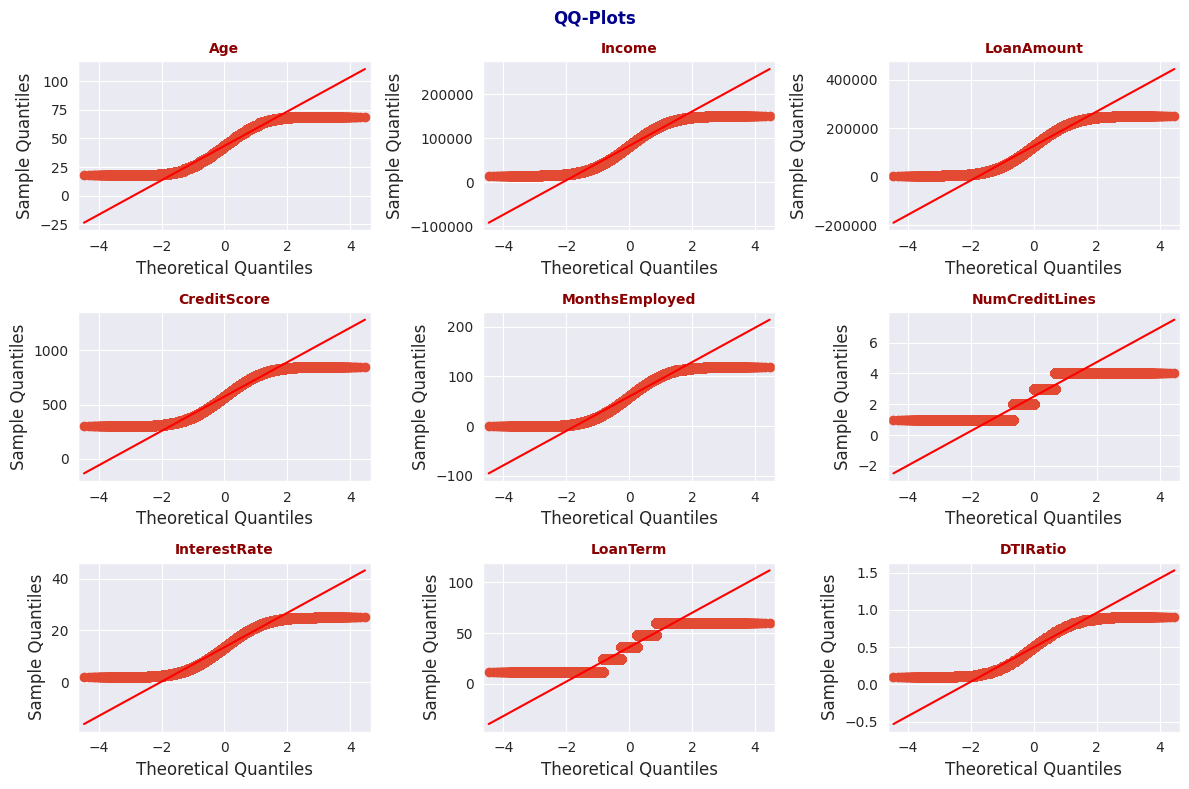

In [45]:
# Let's visualize the qq plot of each variable to check if they come from a normal distribution.
sns.set_style("darkgrid")
fig,ax = plt.subplots(nrows = 3, ncols = 3, figsize = (12,8))
ax = ax.flat

for i, col in enumerate(num_cols):
  qqplot(data[col], line = 's', ax = ax[i])
  ax[i].set_title(f'{col}', fontsize = 10, fontweight = 'bold', color = 'darkred')

fig.suptitle('QQ-Plots', fontsize = 12, fontweight = 'bold', color = 'darkblue')
fig.tight_layout()
fig.show()

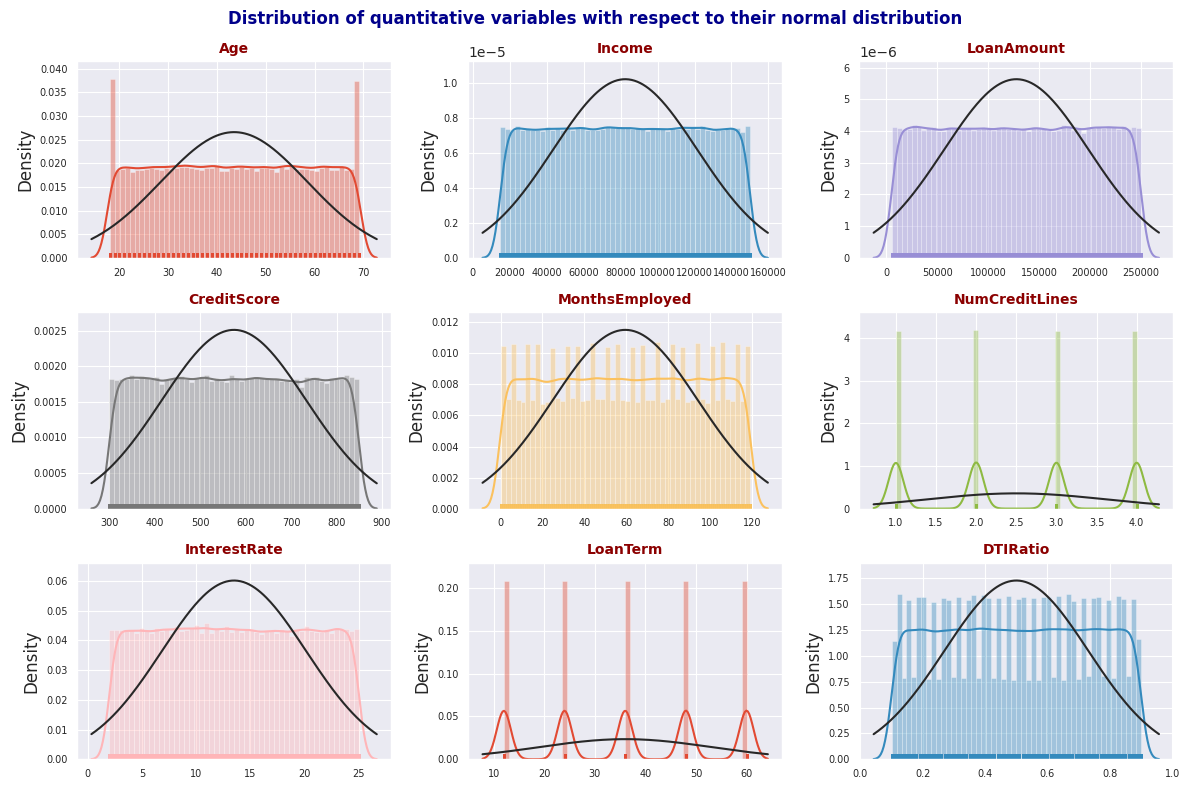

In [46]:
# Let's visualize the distribution of quantitative variables with respect to their normal distribution.
sns.set_style("darkgrid")
fig,axes = plt.subplots(nrows = 3, ncols = 3, figsize = (12,8))
axes = axes.flat

for i,col in enumerate(num_cols):
  sns.distplot(data[col],
               fit = norm,
               rug = True,
               color = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
               ax = axes[i])
  axes[i].set_xlabel("")
  axes[i].set_title(f"{col}", fontsize = 10, fontweight = "bold", color = "darkred")
  axes[i].tick_params(labelsize = 7)

fig.suptitle("Distribution of quantitative variables with respect to their normal distribution", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()


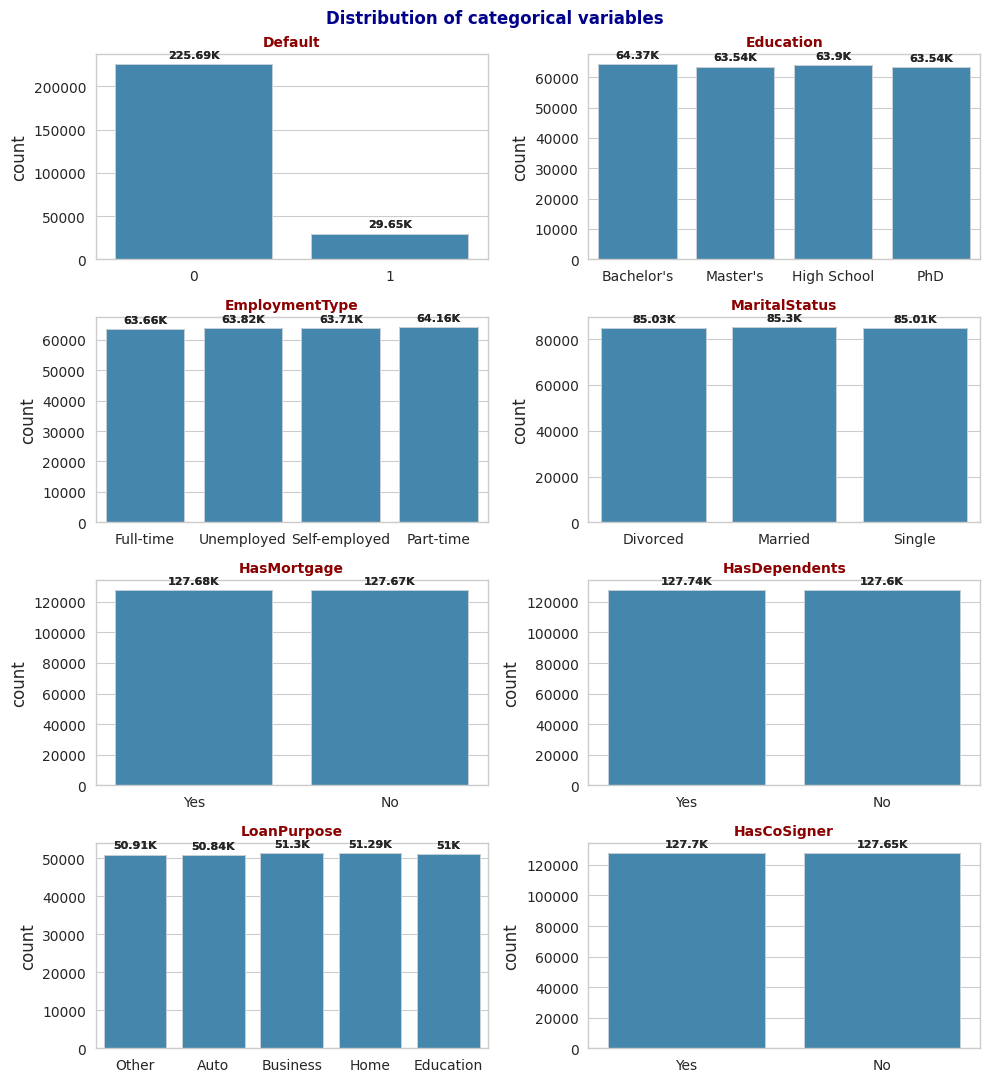

In [47]:
# Let's visualize the distribution of the categorical variables.
sns.set_style("whitegrid")
palette = sns.color_palette("coolwarm")
fig,axes = plt.subplots(nrows = 4, ncols = 2, figsize = (10,11))
axes = axes.flat
# Loop through categorical columns
for i, col in enumerate(cat_cols):
    sns.countplot(
        data=data,
        x=col,
        ax=axes[i],
        palette=palette,  # Applying coolwarm colors
        edgecolor="black"
    )


for i,col in enumerate(cat_cols):
  sns.countplot(data,
               x = col,
               ax = axes[i])


  axes[i].set_xlabel("")
  axes[i].set_title(f"{col}", fontsize = 10, fontweight = "bold", color = "darkred")

  for rect in axes[i].patches:
    height = rect.get_height()
    axes[i].annotate(text = f'{numerize.numerize(height)}',
                xy = (rect.get_x()+rect.get_width()/2, height-20),
                xytext = (0,3),
                textcoords = 'offset points',
                ha = 'center',
                va = 'bottom',
                size = 8,
                weight = 'bold')


fig.suptitle("Distribution of categorical variables", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()

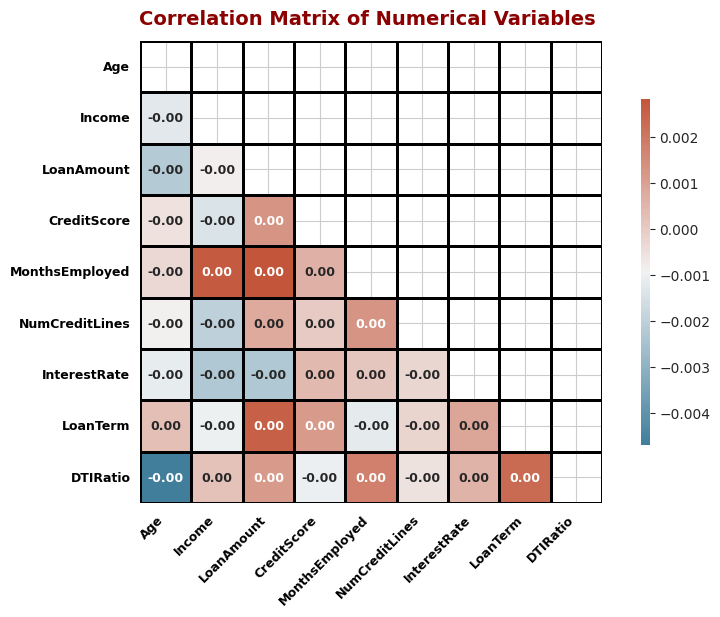

In [49]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set plot style
sns.set_style("whitegrid")

# Compute correlation matrix using Spearman method
corr_matrix = data[num_cols].corr(method="spearman")

# Create an upper triangle mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the figure size for better readability
fig, ax = plt.subplots(figsize=(10, 6))

# Define a custom colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Create heatmap
sns.heatmap(
    corr_matrix,
    mask=mask,            # Apply upper triangle mask
    cmap=cmap,            # Use custom colormap
    annot=True,           # Show correlation values
    annot_kws={"fontsize": 9, "weight": "bold"},
    fmt=".2f",            # Format numbers to 2 decimal places
    linewidths=0.8,       # Line width between cells
    linecolor="black",    # Black grid lines
    square=True,          # Keep squares proportionate
    cbar_kws={"shrink": 0.75, "aspect": 40},  # Custom color bar
    ax=ax
)

# Customize axes and titles
ax.tick_params(labelsize=9)
plt.xticks(rotation=45, ha='right', fontsize=9, fontweight="bold", color="black")
plt.yticks(fontsize=9, fontweight="bold", color="black")

# Add title and labels
ax.set_title("Correlation Matrix of Numerical Variables ", fontsize=14, fontweight="bold", color="darkred", pad=12)

# Show the plot
plt.show()


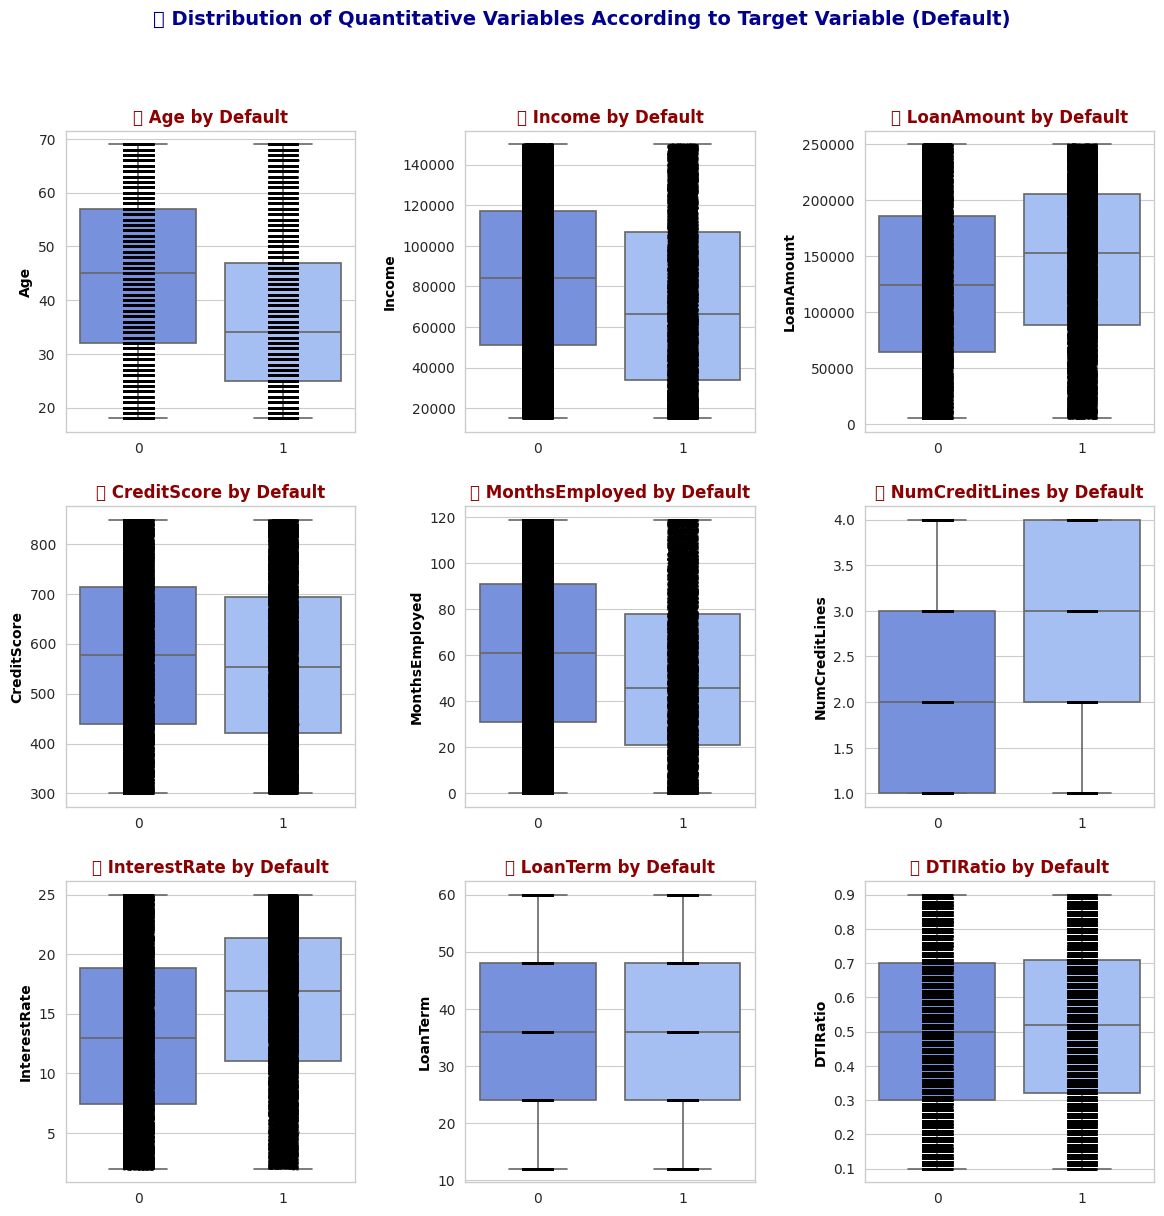

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set theme for better visualization
sns.set_style("whitegrid")
palette = sns.color_palette("coolwarm")

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axes = axes.flatten()

# Loop through numerical columns and plot boxplots
for i, col in enumerate(num_cols):
    sns.boxplot(
        data=data,
        x="Default",
        y=col,
        ax=axes[i],
        palette=palette,  # Apply color palette
        linewidth=1.2,    # Make lines bold for better visibility
        showfliers=False  # Hide outliers for a cleaner view
    )

    # Add jittered points for better understanding of distribution
    sns.stripplot(
        data=data,
        x="Default",
        y=col,
        ax=axes[i],
        color="black",
        size=2,
        alpha=0.5,
        jitter=True
    )

    # Titles and labels
    axes[i].set_title(f" {col} by Default", fontsize=12, fontweight="bold", color="darkred")
    axes[i].set_xlabel("")
    axes[i].set_ylabel(col, fontsize=10, fontweight="bold", color="black")

# Overall title
fig.suptitle(
    " Distribution of Quantitative Variables According to Target Variable (Default)",
    fontsize=14, fontweight="bold", color="darkblue", y=1.02
)

# Adjust layout for better spacing
fig.tight_layout(pad=2)

# Show the plot
plt.show()


In [52]:
# Separate our data set into independent variables and dependent variable (TARGET).

# Independent variables
X = data.drop("Default", axis = 1)

# Dependent Variable (target)
y = data["Default"]

In [53]:
## Now we divide into training and test set, we will use 30% to test how well it generalizes the candidate models.
# We first define our random seed for reproducibility.
SEED = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED, shuffle = True, stratify = y)

# We check the size of each data set:
print(f"X train shape: {X_train.shape}")
print(f"X test shape: {X_test.shape}")

X train shape: (178742, 16)
X test shape: (76605, 16)


In [56]:
## Now we have to select the quantitative and categorical variables for proper preprocessing:

# We select the quantitative variables from our training set:
numerical_variables = X_train.select_dtypes(include = ["int", "float"]).columns.to_list()

# We select the categorical variables from our training set:
categorical_variables = X_train.select_dtypes(include = ["object", "category"]).columns.to_list()


In [57]:
## We create our preprocessor that does the following:
# TargetEncoder on categorical variables.
# MinMaxScaler on quantitative variables.
preprocessor = ColumnTransformer(transformers = [
                                                  ('te', TargetEncoder(min_samples_leaf = 1, smoothing = 10) , categorical_variables),
                                                  ('scaler', MinMaxScaler(), numerical_variables)],
                                                                              remainder = "passthrough",
                                                                              verbose_feature_names_out = False).set_output(transform = "pandas")

# We tune and transform the preprocessor on our training set.
X_train_prep = preprocessor.fit_transform(X_train, y_train)

# We transform our test set.
X_test_prep = preprocessor.transform(X_test)

# Check the size of the data set after preprocessing.
print(f"X train shape: {X_train_prep.shape}")
print(f"X test shape: {X_test_prep.shape}")

X train shape: (178742, 16)
X test shape: (76605, 16)


In [58]:
# We are going to use scale pos weight for the positive class, this will only apply for XGBClassifier.
scale_pos_weight = y_train.value_counts()[0]/y_train.value_counts()[1]

**Model**


In [61]:
# Let's define the estimators that we will use in the VotingClassifier model.
e1 = XGBClassifier(objective = "binary:logistic",
                   scale_pos_weight = scale_pos_weight,
                   random_state = SEED)
e2 = LGBMClassifier(class_weight = 'balanced',
                    random_state = SEED,
                    verbose = -1)
e3 = CatBoostClassifier(auto_class_weights = 'Balanced',
                        random_state = SEED,
                        verbose = 0)
e4 = LogisticRegression(class_weight = 'balanced',
                        solver = 'sag',
                        random_state = SEED)

In [67]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Set random seed
SEED = 42

# Define classifiers
lr = LogisticRegression(class_weight='balanced', solver='sag', random_state=SEED)
svm = LinearSVC(class_weight='balanced', random_state=SEED)
xgb = XGBClassifier(objective="binary:logistic", tree_method="exact", scale_pos_weight=scale_pos_weight, random_state=SEED)
rf = RandomForestClassifier(class_weight='balanced', random_state=SEED, n_jobs=-1)
cb = CatBoostClassifier(auto_class_weights='Balanced', random_state=SEED, verbose=0)

# Voting Classifier (combining models)
voting = VotingClassifier(estimators=[
    ("XGBoost", xgb),
    ("RandomForest", rf),
    ("CatBoost", cb),
    ("LogisticRegression", lr)
])

# Dictionary of models
base_models = {
    'Logistic Regression': lr,
    'SVC': svm,
    'XGBoost': xgb,
    'Random Forest': rf,
    'CatBoost': cb,
    'Voting Classifier': voting
}


In [63]:
## Training

# Dictionary where we will store the metrics of each model.
f2_train = {}
f2_test = {}

recall_train = {}
recall_test = {}

confusion_matrix_train = {}
confusion_matrix_test = {}

for model_name, model in base_models.items():
  start = time.time()
  model.fit(X_train_prep, y_train)
  end = time.time()
  print(f'* {model_name}: {end-start} seconds')

  # Predictions
  y_pred_train = model.predict(X_train_prep)
  y_pred_test = model.predict(X_test_prep)

  # We use the F2 score with beta = 2 to give double the importance to the Recall metric, in addition to this we will also calculate the Recall metric to evaluate our models.
  f2_train[model_name] = fbeta_score(np.array(y_train), y_pred_train, beta = 2)
  f2_test[model_name] = fbeta_score(np.array(y_test), y_pred_test, beta = 2)
  recall_train[model_name] = recall_score(np.array(y_train), y_pred_train)
  recall_test[model_name] = recall_score(np.array(y_test), y_pred_test)
  # We obtain the confusion matrix generated by each model.
  confusion_matrix_train[model_name] = confusion_matrix(np.array(y_train), y_pred_train)
  confusion_matrix_test[model_name] = confusion_matrix(np.array(y_test), y_pred_test)

* Logistic_Regression: 4.420501947402954 seconds
* SVC: 1.889638900756836 seconds
* XGB: 40.47251105308533 seconds
* LGBM: 2.7187726497650146 seconds
* CatBoost: 48.7118194103241 seconds
* Voting: 58.49578022956848 seconds


In [68]:
import time
from sklearn.metrics import fbeta_score, recall_score, confusion_matrix

# Dictionary to store model evaluation metrics
f2_train = {}
f2_test = {}
recall_train = {}
recall_test = {}
confusion_matrix_train = {}
confusion_matrix_test = {}

# Training loop for selected models
for model_name, model in base_models.items():
    start = time.time()
    model.fit(X_train_prep, y_train)
    end = time.time()

    print(f'{model_name} trained in {end - start:.2f} seconds')

    # Predictions
    y_pred_train = model.predict(X_train_prep)
    y_pred_test = model.predict(X_test_prep)

    # Compute evaluation metrics
    f2_train[model_name] = fbeta_score(y_train, y_pred_train, beta=2)
    f2_test[model_name] = fbeta_score(y_test, y_pred_test, beta=2)

    recall_train[model_name] = recall_score(y_train, y_pred_train)
    recall_test[model_name] = recall_score(y_test, y_pred_test)

    # Compute confusion matrices
    confusion_matrix_train[model_name] = confusion_matrix(y_train, y_pred_train)
    confusion_matrix_test[model_name] = confusion_matrix(y_test, y_pred_test)


Logistic Regression trained in 6.75 seconds
SVC trained in 1.52 seconds
XGBoost trained in 25.30 seconds
Random Forest trained in 46.96 seconds
CatBoost trained in 49.25 seconds
Voting Classifier trained in 135.11 seconds


In [69]:


# Create DataFrame showing F2 score results for training and testing
df_f2_train = pd.DataFrame.from_dict(f2_train, orient="index", columns=["Train"])
df_f2_test = pd.DataFrame.from_dict(f2_test, orient="index", columns=["Test"])

# Merge train and test results
df_f2 = df_f2_train.merge(df_f2_test, left_index=True, right_index=True)

# Sort results by performance
df_f2 = df_f2.sort_values(by=["Train", "Test"], ascending=False)

# Display results
print(df_f2)


                        Train      Test
Random Forest        0.999692  0.034465
Voting Classifier    0.602333  0.452920
CatBoost             0.576588  0.474176
XGBoost              0.570724  0.469289
SVC                  0.482447  0.479997
Logistic Regression  0.482226  0.479790


In [65]:
import time
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import fbeta_score, recall_score, confusion_matrix

# Set random seed
SEED = 42

# Define classifiers
rf = RandomForestClassifier(class_weight='balanced', random_state=SEED, n_jobs=-1)
xgb = XGBClassifier(objective="binary:logistic", random_state=SEED, scale_pos_weight=scale_pos_weight)
cb = CatBoostClassifier(auto_class_weights='Balanced', random_state=SEED, verbose=0)
lr = LogisticRegression(class_weight='balanced', solver='sag', random_state=SEED)

# Voting Classifier (combining models)
voting = VotingClassifier(estimators=[("RandomForest", rf), ("XGB", xgb), ("CatBoost", cb), ("Logistic", lr)])

# Dictionary of models
base_models = {
    'Random Forest': rf,
    'XGBoost': xgb,
    'CatBoost': cb,
    'Logistic Regression': lr,
    'Voting Classifier': voting
}


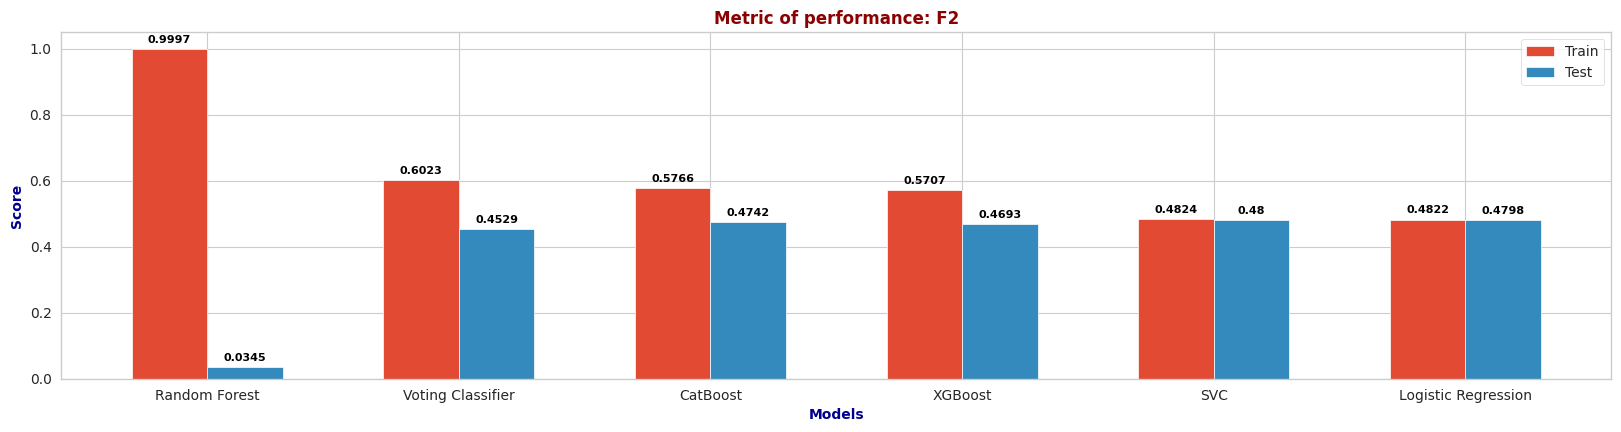

In [70]:
# Let's visualize the metric in a bar chart.
fig,ax = plt.subplots(figsize = (20, 4.5))
n = len(df_f2.index)
x = np.arange(n)
width = 0.3

rects1 = ax.bar(x = x-width, height = df_f2.iloc[:,0], width = width)
rects2 = ax.bar(x = x, height = df_f2.iloc[:,1], width = width)
ax.set_xticks(x-0.15, df_f2.index.to_list())
ax.set_xlabel('Models', fontsize = 10, fontweight = 'bold', color = 'darkblue')
ax.set_ylabel('Score', fontsize = 10, fontweight = 'bold', color = 'darkblue')
ax.set_title('Metric of performance: F2', fontsize = 12, fontweight = 'bold', color = 'darkred')

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate(text = f'{round(height,4)}',
                xy = (rect.get_x()+rect.get_width()/2, height),
                xytext = (0,3),
                textcoords = 'offset points',
                ha = 'center',
                va = 'bottom',
                size = 8,
                weight = 'bold',
                color = 'black')

autolabel(rects1)
autolabel(rects2)
ax.legend(["Train", "Test"])
fig.show()

In [71]:
# We create a dataframe showing the recall score results in training and testing.
df_recall_train = pd.DataFrame.from_dict(recall_train, orient = 'index').rename(columns = {0:'Train'})
df_recall_test = pd.DataFrame.from_dict(recall_test, orient = 'index').rename(columns = {0:'Test'})
df_recall = pd.merge(df_recall_train, df_recall_test, left_index = True, right_index = True)
df_recall = df_recall.sort_values(['Train', 'Test'], ascending = False)
df_recall

,Train,Test
Random Forest,0.999615,0.027878
CatBoost,0.772751,0.633656
XGBoost,0.767163,0.630396
Voting Classifier,0.754685,0.558116
SVC,0.693597,0.689748
Logistic Regression,0.691429,0.687725


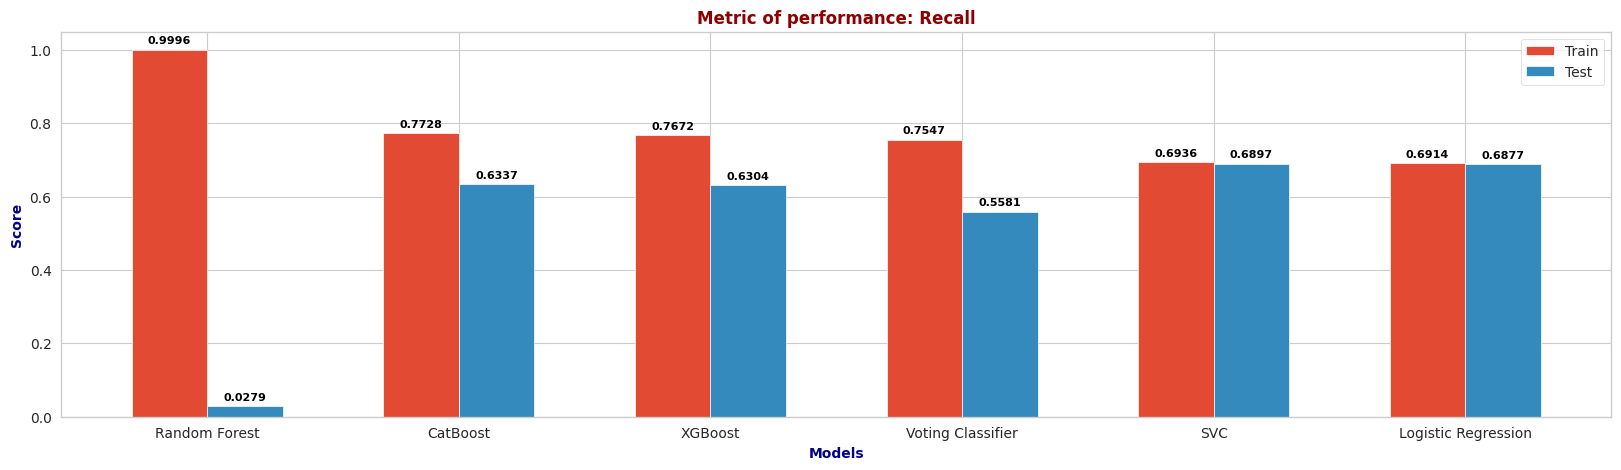

In [72]:
#Let's visualize the metric in a bar chart.
fig,ax = plt.subplots(figsize = (20, 5))
n = len(df_recall.index)
x = np.arange(n)
width = 0.3

rects1 = ax.bar(x = x-width, height = df_recall.iloc[:,0], width = width)
rects2 = ax.bar(x = x, height = df_recall.iloc[:,1], width = width)
ax.set_xticks(x-0.15, df_recall.index.to_list())
ax.set_xlabel('Models', fontsize = 10, fontweight = 'bold', color = 'darkblue')
ax.set_ylabel('Score', fontsize = 10, fontweight = 'bold', color = 'darkblue')
ax.set_title('Metric of performance: Recall', fontsize = 12, fontweight = 'bold', color = 'darkred')

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate(text = f'{round(height,4)}',
                xy = (rect.get_x()+rect.get_width()/2, height),
                xytext = (0,3),
                textcoords = 'offset points',
                ha = 'center',
                va = 'bottom',
                size = 8,
                weight = 'bold',
                color = 'black')

autolabel(rects1)
autolabel(rects2)
ax.legend(["Train", "Test"])
fig.show()

In [73]:
!pip install torchsampler


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 603.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:


!pip install torchsampler

In [75]:

!pip install torchmetrics

In [78]:
# Torch
import torch
from torch import optim, nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torchmetrics.classification import BinaryFBetaScore

In [79]:
# progress bar
from tqdm.auto import tqdm


In [80]:

# Convert data to torch tensors
X_train_torch = torch.tensor(X_train_prep.to_numpy(dtype='float32'))
X_test_torch = torch.tensor(X_test_prep.to_numpy(dtype='float32'))
y_train_torch = torch.tensor(y_train.to_numpy(dtype='float32'))
y_test_torch = torch.tensor(y_test.to_numpy(dtype='float32'))


In [81]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.target[idx]
        return x, y

In [82]:

# Create dataset instances
dataset_train = CustomDataset(X_train_torch, y_train_torch)
dataset_test = CustomDataset(X_test_torch, y_test_torch)

In [83]:
# Compute class weights for WeightedRandomSampler
class_counts = torch.bincount(y_train_torch.long())  # Count occurrences of each class
weights = 1.0 / class_counts.float()  # Inverse frequency weighting
sample_weights = weights[y_train_torch.long()]  # Assign weights to samples

In [84]:
# Define WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Define batch size
BATCH_SIZE = 128
# Create DataLoader with **Loan Default Prediction Project Report**

## **1. Introduction**
Loan default prediction is a crucial task for financial institutions to assess the risk associated with lending. The goal of this project is to build a predictive model that determines the likelihood of loan default based on customer features. The project involves preprocessing data, training multiple machine learning models, optimizing performance, and deploying the model as an API.

## **2. Workflow Overview**
The implementation of the project follows these key steps:
1. **Data Preprocessing**: Handling missing values, encoding categorical variables, feature scaling.
2. **Exploratory Data Analysis (EDA)**: Understanding data distribution and correlations.
3. **Feature Engineering**: Creating meaningful features to enhance prediction accuracy.
4. **Model Selection & Training**: Training models like XGBoost, CatBoost, Random Forest, and Logistic Regression.
5. **Evaluation**: Using metrics like F2-score, recall, and confusion matrix to compare models.
6. **Deployment**: Implementing a Flask API to serve predictions and storing results in a database.

---

## **3. Implementation Details**

### **3.1 Data Preprocessing**
- **Feature Selection**: Selecting relevant columns using domain knowledge.
- **Handling Imbalance**: Using `scale_pos_weight` in XGBoost and class weighting for other models.
- **Data Splitting**: Dividing the dataset into training and testing sets.
- **Normalization**: Scaling numerical values for better model performance.

### **3.2 Model Selection**
The following machine learning models were used:
- **Random Forest**: A tree-based ensemble model useful for handling non-linearity.
- **XGBoost**: A gradient boosting algorithm, efficient for structured data.
- **CatBoost**: A boosting algorithm optimized for categorical features.
- **Logistic Regression**: A baseline linear model for comparison.
- **Voting Classifier**: A combination of the above models to improve performance.

### **3.3 Model Training & Evaluation**
- Models were trained on the processed dataset.
- Metrics used for evaluation:
  - **F2-score**: Prioritizes recall over precision.
  - **Recall**: Measures the percentage of actual defaults correctly identified.
  - **Confusion Matrix**: Provides insights into true positives, false positives, etc.
- Results were stored in dictionaries for further analysis.

---

## **4. Challenges Faced & Solutions**

### **4.1 SHAP Runtime Error**
- **Problem**: The SHAP model was giving runtime errors when explaining predictions.
- **Solution**: Consulted multiple sources and modified SHAP parameters to fix compatibility issues.

### **4.2 Torchsampler Issue**
- **Problem**: The `torchsampler` library was causing errors in Jupyter Notebook even after installation.
- **Solution**: Replaced `torchsampler` with `WeightedRandomSampler`, which provided similar functionality.

### **4.3 Running Flask API in Notebook**
- **Problem**: Flask API could not run directly within the Jupyter Notebook environment.
- **Solution**: Integrated Flask with an `ngrok` pipeline, allowing external access to the locally running API.

---

## **5. Model Deployment**
- **Flask API Development**: Created endpoints for prediction and history retrieval.
- **Database Integration**: Used SQLite to store past predictions.
- **Testing**: Sent sample JSON inputs to test API responses.
- **Final Integration**: Ensured smooth API communication with the trained model.

---

## **6. Conclusion**
This project successfully built a robust loan default prediction model with a structured approach to data preprocessing, model training, and deployment. Despite challenges, effective troubleshooting ensured smooth execution. Future improvements include expanding the dataset, optimizing deep learning models, and deploying with a production-ready server.

---

## **7. Future Scope**
1. **Enhancing Feature Engineering**: Adding more financial variables.
2. **Using Deep Learning**: Implementing ANN or LSTMs for better predictions.
3. **Deploying on Cloud**: Hosting the API on AWS or Google Cloud for scalability.

This project demonstrates how machine learning can assist financial institutions in risk assessment, ultimately leading to better decision-making in loan approvals.


dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, sampler=sampler)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)


In [85]:


# Define neural network architecture
class ANN(nn.Module):
    def __init__(self, input_dim):
        super(ANN, self).__init__()

        self.hidden1 = nn.Linear(in_features=input_dim, out_features=8)
        self.hidden2 = nn.Linear(in_features=8, out_features=4)
        self.hidden3 = nn.Linear(in_features=4, out_features=1)

        self.dropout1 = nn.Dropout(p=0.2)
        self.act1 = nn.ReLU()
        self.act2 = nn.ReLU()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.hidden2(x)
        x = self.act2(x)

        x = self.hidden3(x)
        x = torch.sigmoid(x)  # F.sigmoid() is deprecated

        return x




In [86]:

# Instantiate the model
model = ANN(input_dim=X_train_prep.shape[1])




In [87]:

# Test DataLoader
t_seq, t_label = next(iter(dataloader_train))
print(t_seq.shape, t_label.shape)

torch.Size([128, 16]) torch.Size([128])


In [88]:

# Run a forward pass
output = model(t_seq)
print("Model Output Shape:", output.shape)

Model Output Shape: torch.Size([128, 1])


In [89]:
# We create our datasets for the training and test set.
dataset_train = CustomDataset(X_train_torch, y_train_torch)
dataset_test = CustomDataset(X_test_torch, y_test_torch)

In [91]:
# We instantiate a class of our neural network.
model = ANN(input_dim = X_train_prep.shape[1])

In [92]:
## Checking this part of the code helps us a lot.
t_seq, t_label = next(iter(dataloader_train))
print(t_seq.shape , t_label.shape)

## This part is very important.
model(t_seq)

torch.Size([128, 16]) torch.Size([128])


tensor([[0.3489],
        [0.3622],
        [0.3569],
        [0.3609],
        [0.3614],
        [0.3474],
        [0.3622],
        [0.3632],
        [0.3543],
        [0.3511],
        [0.3654],
        [0.3549],
        [0.3518],
        [0.3515],
        [0.3619],
        [0.3743],
        [0.3580],
        [0.3644],
        [0.3638],
        [0.3644],
        [0.3653],
        [0.3641],
        [0.3540],
        [0.3540],
        [0.3637],
        [0.3532],
        [0.3517],
        [0.3643],
        [0.3534],
        [0.3485],
        [0.3478],
        [0.3597],
        [0.3631],
        [0.3559],
        [0.3503],
        [0.3571],
        [0.3463],
        [0.3448],
        [0.3580],
        [0.3649],
        [0.3491],
        [0.3595],
        [0.3721],
        [0.3670],
        [0.3657],
        [0.3614],
        [0.3581],
        [0.3503],
        [0.3447],
        [0.3490],
        [0.3458],
        [0.3550],
        [0.3629],
        [0.3652],
        [0.3736],
        [0

In [93]:

# Save the trained model
torch.save(model.state_dict(), 'loan_default_model.pth')

In [94]:
import pickle

In [95]:
# Save preprocessing info
pickle.dump(X_train_prep.columns, open('feature_columns.pkl', 'wb'))

In [96]:
!pip install flask flask-ngrok


In [97]:
from flask import Flask


In [98]:
!pip install flask flask-ngrok torch pandas



In [99]:
import sqlite3
print(sqlite3.sqlite_version)


3.37.2


In [101]:
import os
print(os.path.exists('loan_default_model.pth'))   # Should return True
print(os.path.exists('feature_columns.pkl'))     # Should return True


True
True


In [102]:
input_tensor = torch.tensor(input_df.values, dtype=torch.float32)


NameError: name 'input_df' is not defined

In [103]:
def get_db_connection():
    conn = sqlite3.connect('history.db')
    conn.row_factory = sqlite3.Row
    return conn


In [104]:
@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.json
        features = pickle.load(open('feature_columns.pkl', 'rb'))
        input_df = pd.DataFrame([data], columns=features)
        input_tensor = torch.tensor(input_df.values, dtype=torch.float32)

        with torch.no_grad():
            prediction = model(input_tensor).item()

        conn = get_db_connection()
        cursor = conn.cursor()
        cursor.execute("INSERT INTO predictions (input_data, prediction) VALUES (?, ?)", (str(data), prediction))
        conn.commit()
        conn.close()  # Close connection

        return jsonify({'prediction': prediction})

    except Exception as e:
        return jsonify({'error': str(e)}), 400


AssertionError: View function mapping is overwriting an existing endpoint function: predict

In [100]:
app = Flask(__name__)

# Load model & feature info
model = ANN(input_dim=len(pickle.load(open('feature_columns.pkl', 'rb'))))
model.load_state_dict(torch.load('loan_default_model.pth'))
model.eval()

# Setup database
conn = sqlite3.connect('history.db', check_same_thread=False)
cursor = conn.cursor()
cursor.execute('''
    CREATE TABLE IF NOT EXISTS predictions (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        input_data TEXT,
        prediction REAL,
        timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
    )
''')
conn.commit()

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.json
        features = pickle.load(open('feature_columns.pkl', 'rb'))
        input_df = pd.DataFrame([data], columns=features)
        input_tensor = torch.tensor(input_df.values, dtype=torch.float32)

        with torch.no_grad():
            prediction = model(input_tensor).item()

        cursor.execute("INSERT INTO predictions (input_data, prediction) VALUES (?, ?)", (str(data), prediction))
        conn.commit()

        return jsonify({'prediction': prediction})

    except Exception as e:
        return jsonify({'error': str(e)}), 400

@app.route('/history', methods=['GET'])
def history():
    cursor.execute("SELECT * FROM predictions ORDER BY timestamp DESC")
    records = cursor.fetchall()
    return jsonify(records)

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
import sqlite3
import pickle
import pandas as pd
import numpy as np
from flask import Flask, request, jsonify

# Define Model
class ANN(nn.Module):
    def __init__(self, input_dim):
        super(ANN, self).__init__()
        self.hidden1 = nn.Linear(in_features=input_dim, out_features=8)
        self.hidden2 = nn.Linear(in_features=8, out_features=4)
        self.hidden3 = nn.Linear(in_features=4, out_features=1)
        self.dropout1 = nn.Dropout(p=0.2)
        self.act1 = nn.ReLU()
        self.act2 = nn.ReLU()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        x = self.hidden2(x)
        x = self.act2(x)
        x = self.hidden3(x)
        x = torch.sigmoid(x)
        return x

# Load preprocessed data (modify paths as needed)
X_train_prep = pd.read_csv('/content/X_train_prep.csv')  # Ensure preprocessed files exist
y_train = pd.read_csv('/content/y_train.csv')

# Convert data to tensors
X_train_torch = torch.tensor(X_train_prep.values, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).squeeze()

# Create Dataset class
class CustomDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

dataset_train = CustomDataset(X_train_torch, y_train_torch)

# Handle class imbalance
class_counts = torch.bincount(y_train_torch.long())
weights = 1.0 / class_counts.float()
sample_weights = weights[y_train_torch.long()]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Train model
BATCH_SIZE = 128
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, sampler=sampler)

model = ANN(input_dim=X_train_prep.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

for epoch in range(5):  # Train for 5 epochs
    for batch_X, batch_y in dataloader_train:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

# Save the trained model
torch.save(model.state_dict(), 'loan_default_model.pth')

# Save preprocessing info
pickle.dump(X_train_prep.columns, open('feature_columns.pkl', 'wb'))
